In [1]:
library(magrittr)
library(lme4)
library(optimx)
library(dplyr)
library(readr)
library(jtools)
library(reticulate)
library(PerformanceAnalytics)
library(tidyverse)
library(ggcorrplot)
library(ggplot2)

Loading required package: Matrix


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



######################### Warning from 'xts' package ##########################
#                                                                             #
# The dplyr lag() function breaks how base R's lag() function is supposed to  #
# work, which breaks lag(my_xts). Calls to lag(my_xts) that you type or       #
# source() into this session won't work correctly.                            #
#                                                                             #
# Use stats::lag() to make sure you're not using dplyr::lag(), or you can add #
# conflictRules('dplyr', exc

In [2]:
# Stage 1
my_data <- read.delim(file = '/kaggle/input/predicting-learning-outcomes/ds5165_student_step_All_Data_7337_2022_0107_094330.txt')
names(my_data)

[1] "Row"                                "Sample"                            
 [3] "Anon.Student.Id"                    "Problem.Hierarchy"                 
 [5] "Problem.Name"                       "Problem.View"                      
 [7] "Step.Name"                          "Step.Start.Time"                   
 [9] "First.Transaction.Time"             "Correct.Transaction.Time"          
[11] "Step.End.Time"                      "Step.Duration..sec."               
[13] "Correct.Step.Duration..sec."        "Error.Step.Duration..sec."         
[15] "First.Attempt"                      "Incorrects"                        
[17] "Hints"                              "Corrects"                          
[19] "Condition"                          "KC..Default."                      
[21] "Opportunity..Default."              "Predicted.Error.Rate..Default."    
[23] "KC..Single.KC."                     "Opportunity..Single.KC."           
[25] "Predicted.Error.Rate..Single.KC."   "KC..Unique.step."                  
[27] "Opportunity..Unique.step."          "Predicted.Error.Rate..Unique.step."

In [3]:
my_data <- my_data %>%
  filter(Opportunity..Default. != "" & First.Attempt != "") %>%
  group_by(KC..Default., Anon.Student.Id) %>%
  arrange(First.Transaction.Time) %>%
  mutate(Opportunity..Default.Processed = row_number()) %>%
  ungroup()
my_data <- my_data %>%
  rename(
    individual = Anon.Student.Id,
    KC = KC..Default.,
    opportunity = Opportunity..Default.Processed,
    response = First.Attempt
  ) %>%
  arrange(individual, KC) %>%
  group_by(individual, KC) %>%
  mutate(
    opportunity_reverse = max(opportunity) - opportunity
  ) %>%
  ungroup() %>%
  mutate(
    response = ifelse(response == "correct", 1, 0),
    opportunity0 = opportunity - 1
  ) %>%
  filter(!(is.na(KC) | KC == "" | KC == "0" | KC == 0))

In [4]:
summary(my_data$opportunity0)
summary(my_data$opportunity_reverse)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    3.00    8.00   11.89   16.00   96.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    3.00    8.00   11.89   16.00   96.00 

In [5]:
# # Fit the glmer model
# start.time <- Sys.time()
# model_iafm <- my_data %>%
#   glmer(response ~ opportunity0 + (opportunity0 | KC) + (opportunity0 | individual),
#         data = ., family = binomial(), nAGQ = 0)
# end.time <- Sys.time()

# # Print fitting time
# round(end.time - start.time, 2)

# # Save the model
# saveRDS(model_iafm, file = "/kaggle/working/model_iafm_5165.rds")

In [6]:
# # Fit the reverse glmer model
# start.time <- Sys.time()
# model_iafm_reverse = my_data %>%
#   glmer(response ~ opportunity_reverse + (opportunity_reverse | KC) + (opportunity_reverse | individual), 
#         data=., family = binomial(), nAGQ = 0)
# end.time <- Sys.time()

# # Print fitting time
# round(end.time - start.time,2)

# # Save the model
# saveRDS(model_iafm_reverse, file = "/kaggle/working/model_iafm_reverse_5165.rds")

In [7]:
model_iafm <- readRDS('/kaggle/input/predicting-learning-outcomes/model_iafm_5165.rds')
model_iafm_reverse <- readRDS('/kaggle/input/predicting-learning-outcomes/model_iafm_reverse_5165.rds')

In [8]:
summ(model_iafm)

MODEL INFO:
Observations: 32458
Dependent Variable: response
Type: Mixed effects generalized linear regression
Error Distribution: binomial
Link function: logit 

MODEL FIT:
AIC = 37774.13, BIC = 37841.23
Pseudo-R² (fixed effects) = 0.04
Pseudo-R² (total) = 0.56 

FIXED EFFECTS:
-------------------------------------------------
                      Est.   S.E.   z val.      p
------------------ ------- ------ -------- ------
(Intercept)          -0.27   0.15    -1.79   0.07
opportunity0          0.04   0.01     3.10   0.00
-------------------------------------------------

RANDOM EFFECTS:
---------------------------------------
   Group       Parameter     Std. Dev. 
------------ -------------- -----------
 individual   (Intercept)      1.04    
 individual   opportunity0     0.02    
     KC       (Intercept)      0.89    
     KC       opportunity0     0.08    
---------------------------------------

Grouping variables:
------------------------------
   Group      # groups   ICC  


In [9]:
summ(model_iafm_reverse)

MODEL INFO:
Observations: 32458
Dependent Variable: response
Type: Mixed effects generalized linear regression
Error Distribution: binomial
Link function: logit 

MODEL FIT:
AIC = 37811.43, BIC = 37878.53
Pseudo-R² (fixed effects) = 0.09
Pseudo-R² (total) = 0.52 

FIXED EFFECTS:
--------------------------------------------------------
                             Est.   S.E.   z val.      p
------------------------- ------- ------ -------- ------
(Intercept)                  0.10   0.16     0.62   0.53
opportunity_reverse         -0.06   0.01    -5.57   0.00
--------------------------------------------------------

RANDOM EFFECTS:
----------------------------------------------
   Group           Parameter        Std. Dev. 
------------ --------------------- -----------
 individual       (Intercept)         0.94    
 individual   opportunity_reverse     0.02    
     KC           (Intercept)         1.01    
     KC       opportunity_reverse     0.06    
--------------------------------

In [10]:
model_iafm_param <- ranef(model_iafm)
model_iafm_reverse_param <- ranef(model_iafm_reverse)

# Export the random effects to a CSV file
write.csv(model_iafm_param, file = "/kaggle/working/model_iafm_param.csv")
write.csv(model_iafm_reverse_param, file = "/kaggle/working/model_iafm_reverse_param.csv")

In [11]:
# Maximum opportunity on each KC
predict_data = my_data %>%
      group_by(individual, KC) %>%
      slice(which.max(opportunity0))
# Predict an end of instruction state for each student on each KC
predict_data$pred_iafm = predict(model_iafm, predict_data,type="response", allow.new.levels=TRUE)
# Average across KCs to get a single predicted value per student
predicted_scores = predict_data %>% 
  group_by(individual) %>%
  summarise(
    PredAvgiAFM = mean(pred_iafm),
)
# Export the predicted value to a CSV file
write.csv(predicted_scores, file = "/kaggle/working/predicted.csv")

In [12]:
# Total opportunity per student
total_opportunity = predict_data %>% 
  group_by(individual) %>%
  summarise(
    TotalOpportunity = sum(opportunity),
)
# Export the predicted value to a CSV file
write.csv(total_opportunity, file = "/kaggle/working/total_opportunity.csv")

In [13]:
# Stage 2
# Join tutor data with test data
student2account_ids_map <- read.delim(file = '/kaggle/input/predicting-learning-outcomes/student_ids_map.txt')
student2account_ids_map = student2account_ids_map %>% rename(individual = `Anon.Student.Id`)
info_test_scores <- read.csv(file = '/kaggle/input/predicting-learning-outcomes/Info_TestScores_Gaming_Cond_MotSurvey_Demog_129Stu.csv')
test_scores = student2account_ids_map %>% left_join(info_test_scores, by="account")
# Join test data with student parameters from stage 1
test_scores = test_scores %>% left_join(predicted_scores, by="individual")
# Join test data with total opportunity
test_scores = test_scores %>% left_join(total_opportunity, by="individual")

In [18]:
# join individual with corresponding init_iAFM
StudentInterceptsiAFM = data.frame(
  individual = row.names(ranef(model_iafm)$individual),
  int_iAFM = ranef(model_iafm)$individual[,1],
  int_iAFM_reverse = ranef(model_iafm_reverse)$individual[,1]
)
StudentInterceptsiAFM$int_iAFM = as.numeric(StudentInterceptsiAFM$int_iAFM) + + as.numeric(coef(summary(model_iafm))[1])
StudentInterceptsiAFM$int_iAFM_reverse = as.numeric(StudentInterceptsiAFM$int_iAFM_reverse) + + as.numeric(coef(summary(model_iafm_reverse))[1])

In [19]:
StudentInterceptsiAFM

individual,int_iAFM,int_iAFM_reverse
<chr>,<dbl>,<dbl>
Stu_00e7976d1e35e69629ea814e7663ae6b,0.044333375,0.31036239
Stu_02ed92b332024cc68a4c042697b1c57c,0.190406415,0.87398508
Stu_0579ea4e9dd6bcf83463cd55a419fd79,-2.496839689,-0.54865720
Stu_05bdce2051525a38318a7eb7f95eec84,-0.005178151,0.38872193
Stu_065c3c6616e42d1fddfbb9547974ba8c,-0.498297179,0.02301365
Stu_0788b750fead0fb0997d51675227d707,0.851971345,1.18871278
Stu_0892bfc0a300449a95aa3b51a7a8a213,0.621131149,0.69257072
Stu_0ac8dd125ce01465481816664835ad25,-0.594052835,-0.43271298
Stu_10dd499fee6bd8bb2c1eea42a810318f,-0.471912842,0.02254869


In [20]:
test_scores = test_scores %>% left_join(StudentInterceptsiAFM, by="individual")
test_scores$learning_gain = test_scores$int_iAFM_reverse - test_scores$int_iAFM

In [21]:
test_scores

individual,account,GamFreq3Level,Pretest3Level,LG3Level,NLG3Level,Pretest,Posttest,LG,NLG,⋯,Ethnicity,ClassPeriod,Class,Lunch,PURMOrFRLunch,PredAvgiAFM,TotalOpportunity,int_iAFM,int_iAFM_reverse,learning_gain
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
Stu_00e7976d1e35e69629ea814e7663ae6b,dd112,High,Med,High,High,0.37,0.60,0.23,0.37,⋯,Majority,DD1,DD,F/R,Yes,0.5070812,245,0.044333375,0.31036239,0.26602901
Stu_02ed92b332024cc68a4c042697b1c57c,dd111,High,High,Low,Low,0.67,0.60,-0.08,-0.21,⋯,Majority,DD1,DD,N,No,0.7219338,358,0.190406415,0.87398508,0.68357867
Stu_0579ea4e9dd6bcf83463cd55a419fd79,dd100,Low,Low,High,Med,0.13,0.37,0.23,0.28,⋯,Majority,DD1,DD,N,No,0.3789256,263,-2.496839689,-0.54865720,1.94818248
Stu_05bdce2051525a38318a7eb7f95eec84,dd159,Med,Low,Med,Med,0.21,0.42,0.21,0.27,⋯,Majority,DD9,DD,N,No,0.5110963,210,-0.005178151,0.38872193,0.39390008
Stu_065c3c6616e42d1fddfbb9547974ba8c,oc189,High,High,Low,Low,0.53,0.30,-0.23,-0.49,⋯,Majority,OC7,OCLA,N,No,0.4364856,256,-0.498297179,0.02301365,0.52131083
Stu_0788b750fead0fb0997d51675227d707,oc162,Med,High,Med,High,0.55,0.71,0.16,0.36,⋯,Majority,OC6,OCMA,N,No,0.6495000,160,0.851971345,1.18871278,0.33674143
Stu_0892bfc0a300449a95aa3b51a7a8a213,oc137,Med,High,High,High,0.55,0.79,0.24,0.53,⋯,Majority,OC6,OCMA,N,No,0.7614241,337,0.621131149,0.69257072,0.07143957
Stu_0ac8dd125ce01465481816664835ad25,oc129,High,Low,High,Med,0.07,0.40,0.33,0.35,⋯,PotentialURM,OC3,OCLA,N,Yes,0.5561448,191,-0.594052835,-0.43271298,0.16133986
Stu_10dd499fee6bd8bb2c1eea42a810318f,dd128,Low,Low,Med,Med,0.21,0.38,0.16,0.22,⋯,Majority,DD6,DD,N,No,0.6247452,198,-0.471912842,0.02254869,0.49446153


In [ ]:
# Model 1: pretest only
cat("model1")
model1 = test_scores %>%
  lm(Posttest ~ Pretest, data = .)
summ(model1)
AIC(model1)
BIC(model1)
logLik(model1)
cat("\n")

# Model 2: pretest + PredAvgiAFM
cat("model2")
model2 = test_scores %>%
  lm(Posttest ~ PredAvgiAFM + Pretest, data = .)
summ(model2)
AIC(model2)
BIC(model2)
logLik(model2)
cat("\n")

# Model 3: pretest + int_iAFM'
cat("model3")
model3 = test_scores %>%
  lm(Posttest ~ int_iAFM + Pretest, data = .)
summ(model3)
AIC(model3)
BIC(model3)
logLik(model3)
cat("\n")

# Model 4: pretest + int_iAFM_reverse
cat("model4")
model4 = test_scores %>%
  lm(Posttest ~ int_iAFM_reverse + Pretest, data = .)
summ(model4)
AIC(model4)
BIC(model4)
logLik(model4)
cat("\n")

# Model 5: pretest + int_iAFM + int_iAFM_reverse
cat("model5")
model5 = test_scores %>%
  lm(Posttest ~ int_iAFM + int_iAFM_reverse + Pretest, data = .)
summ(model5)
AIC(model5)
BIC(model5)
logLik(model5)
cat("\n")

In [ ]:
anova(model1, model2, test="Chisq")
anova(model1, model3, test="Chisq")
anova(model1, model4, test="Chisq")
anova(model1, model5, test="Chisq")
anova(model2, model3, test="Chisq")
anova(model2, model4, test="Chisq")
anova(model2, model5, test="Chisq")
anova(model3, model4, test="Chisq")
anova(model3, model5, test="Chisq")
anova(model4, model5, test="Chisq")

In [ ]:
cor(test_scores[c("Pretest", "Posttest", "TotalOpportunity", "int_iAFM", "int_iAFM_reverse", "PredAvgiAFM")])

In [ ]:
test_scores %>% select (Pretest, Posttest, TotalOpportunity, int_iAFM, int_iAFM_reverse, PredAvgiAFM) %>%
  chart.Correlation(histogram=TRUE, cex.labels = 1)
png("correlation_plot.png", width = 2400, height = 2400)
dev.copy(png, "correlation_plot.png", width = 2400, height = 2400)
dev.off()

In [ ]:
write.csv(test_scores, file = "test_scores.csv")

In [ ]:
# Model 1.2: pretest + TotalOpportunity
test_scores %>%
  lm(Posttest ~ TotalOpportunity + Pretest, data = .) %>%
  summ()

# Model 2.2: pretest + PredAvgiAFM + TotalOpportunity
test_scores %>%
  lm(Posttest ~ TotalOpportunity + PredAvgiAFM + Pretest, data = .) %>%
  summ()

# Model 3.2: pretest + int_iAFM + TotalOpportunity
test_scores %>%
  lm(Posttest ~ TotalOpportunity + int_iAFM + Pretest, data = .) %>%
  summ()

# Model 4.2: pretest + int_iAFM_reverse + TotalOpportunity
test_scores %>%
  lm(Posttest ~ TotalOpportunity + int_iAFM_reverse + Pretest, data = .) %>%
  summ()

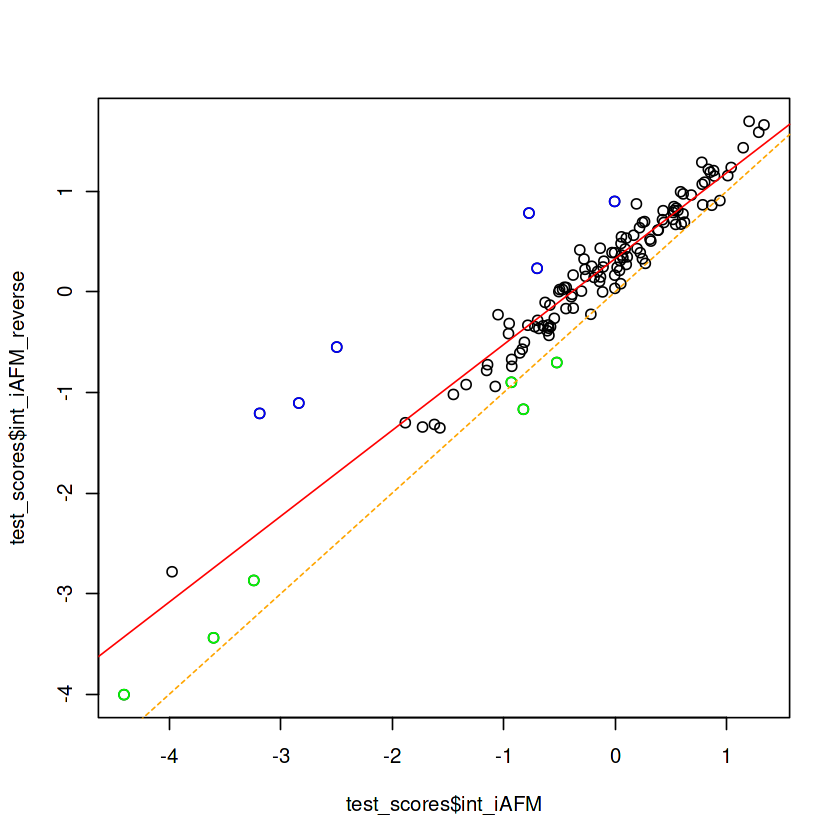

In [22]:
# Analysis of overachievers
linear_model <- lm(int_iAFM_reverse ~ int_iAFM, data = test_scores)

# Predict values using the linear model
predicted_values <- predict(linear_model, newdata = test_scores)

# Set a threshold
threshold_difference <- 0.4

# Calculate the difference between actual and predicted values
difference <- test_scores$int_iAFM_reverse - predicted_values

# Create a new column 'achiever_status'
test_scores$achiever_status <- ifelse(difference > threshold_difference, 1,
                                     ifelse(difference < -threshold_difference, -1, 0))

# Identify overachievers
overachievers <- which(test_scores$achiever_status == 1)
underachievers <- which(test_scores$achiever_status == -1)

# Extract overachiever cases
overachiever_cases <- test_scores[overachievers, ]
underachiever_cases <- test_scores[underachievers, ]

# Visualize results
plot(test_scores$int_iAFM, test_scores$int_iAFM_reverse)
abline(linear_model, col = "red")  # Line of best fit
points(overachiever_cases$int_iAFM, overachiever_cases$int_iAFM_reverse, col = "blue")
points(underachiever_cases$int_iAFM, underachiever_cases$int_iAFM_reverse, col = "green")
# abline(linear_model, col = "yellow")
abline(a = 0, b = 1, col = "orange", lty = 2)

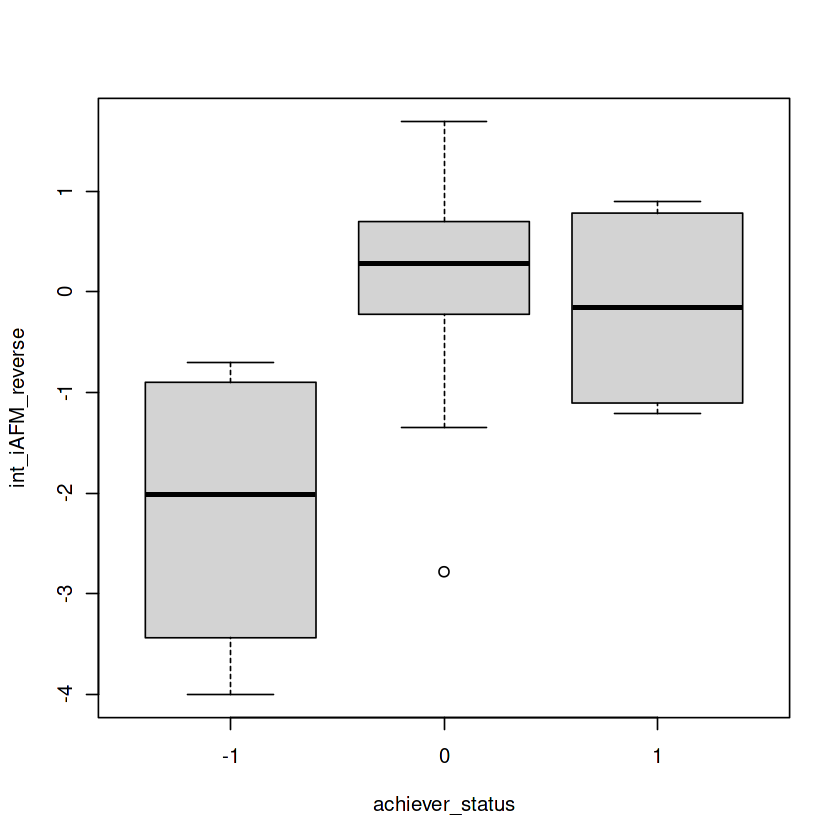

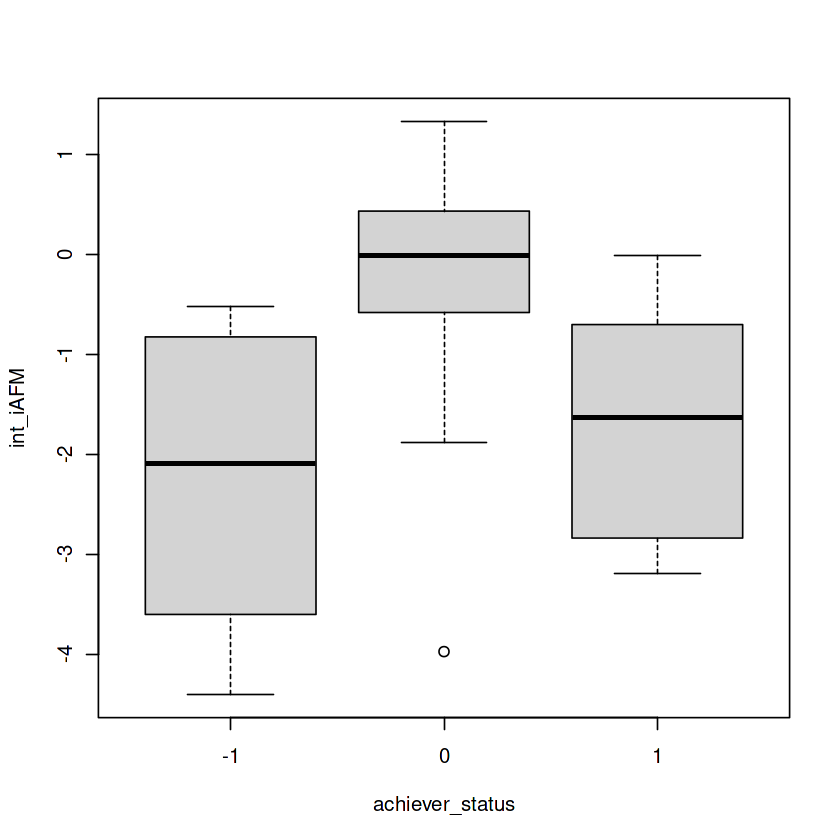

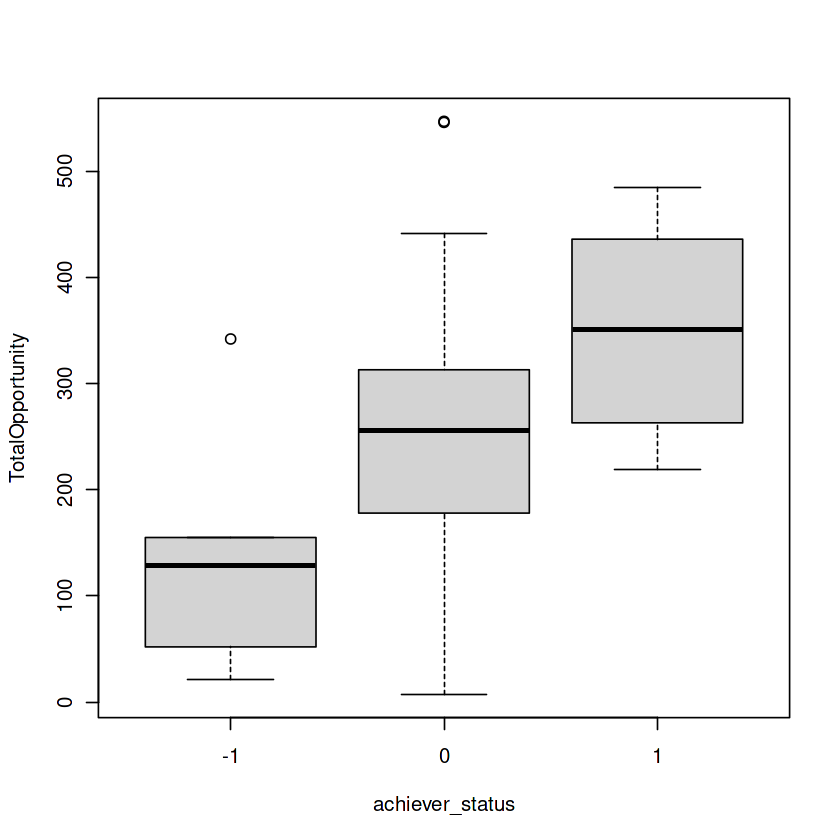

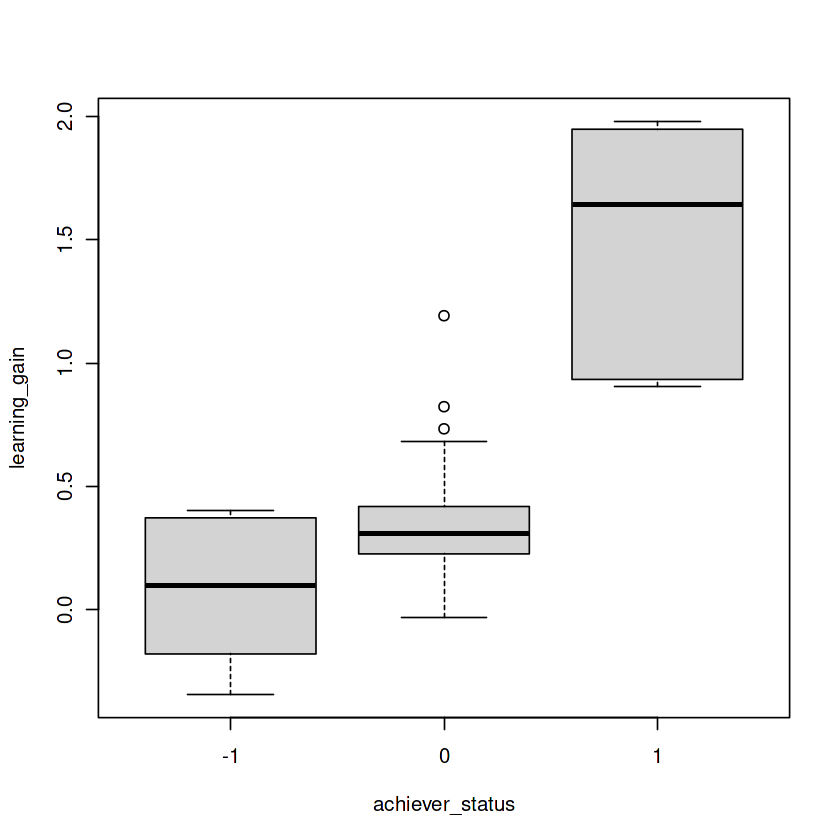

In [24]:
# Box plot for a specific variable
boxplot(int_iAFM_reverse ~ achiever_status, data = test_scores)
boxplot(int_iAFM ~ achiever_status, data = test_scores)
boxplot(TotalOpportunity ~ achiever_status, data = test_scores)
boxplot(learning_gain ~ achiever_status, data = test_scores)

In [ ]:
# Correlation between learning gain and key variables
test_scores$learning_gain = test_scores$int_iAFM_reverse - test_scores$int_iAFM

In [ ]:
summary(test_scores$learning_gain)

In [ ]:
plot(test_scores$TotalOpportunity, test_scores$learning_gain, 
     xlab = "Total Opportunity", ylab = "Learning Gain", main = "Relationship between Total Opportunity and Learning Gain")